## jiamu tang
275 final project

In [1]:
from mne.datasets import eegbci
from mne import concatenate_raws
from mne.io import read_raw_edf

In [2]:
import mne
import numpy as np

STEP 1 — “Load + Montage Standardization” (Align channel names and positions with a standard coordinate system.
STEP 2 — “Band-pass filter (7–30 Hz)”
STEP 3 — “Channel selection (C3, Cz, C4, FC3, CP4…)”
STEP 4 — “Extract events (T1 = left, T2 = right)” (EEG is continuous, but MI is performed in trials starting from task cues.)
STEP 5 — “Epoch (slice trials)” (Convert continuous EEG into fixed-length trials aligned to cues.)
STEP 6 — “Get X, y (the machine learning dataset)”

In [3]:
#data exploration

In [4]:
subject = 1
runs = [3, 7, 11] 

In [5]:
raw_fnames = eegbci.load_data(subject, runs)
print("EDF files to load:")
for f in raw_fnames:
    print(" -", f)


EDF files to load:
 - /Users/chanok/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf
 - /Users/chanok/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R07.edf
 - /Users/chanok/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R11.edf


In [6]:
raw_list = [
    mne.io.read_raw_edf(f, preload=True, verbose=False)
    for f in raw_fnames
]

In [7]:
raw = mne.concatenate_raws(raw_list)


In [8]:
n_signals = raw.info['nchan']
sampling_rate = raw.info['sfreq']
channel_names = raw.ch_names

print("\n===== RAW INFO =====")
print(f"Number of Channels: {n_signals}")
print(f"Sampling Rate: {sampling_rate} Hz")
print(f"Channel Names: {channel_names[:10]} ...") 


===== RAW INFO =====
Number of Channels: 64
Sampling Rate: 160.0 Hz
Channel Names: ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..'] ...


In [9]:
signals = raw.get_data()  

In [10]:
print(f"\nSignals Shape: {signals.shape}")


Signals Shape: (64, 60000)


In [11]:
times = raw.times   

In [12]:
num_channels_to_plot = 16
selected_channels = range(num_channels_to_plot)

duration_sec = 5
num_samples = int(duration_sec * sampling_rate)

signals_plot = signals[:, :num_samples]
times_plot = times[:num_samples]

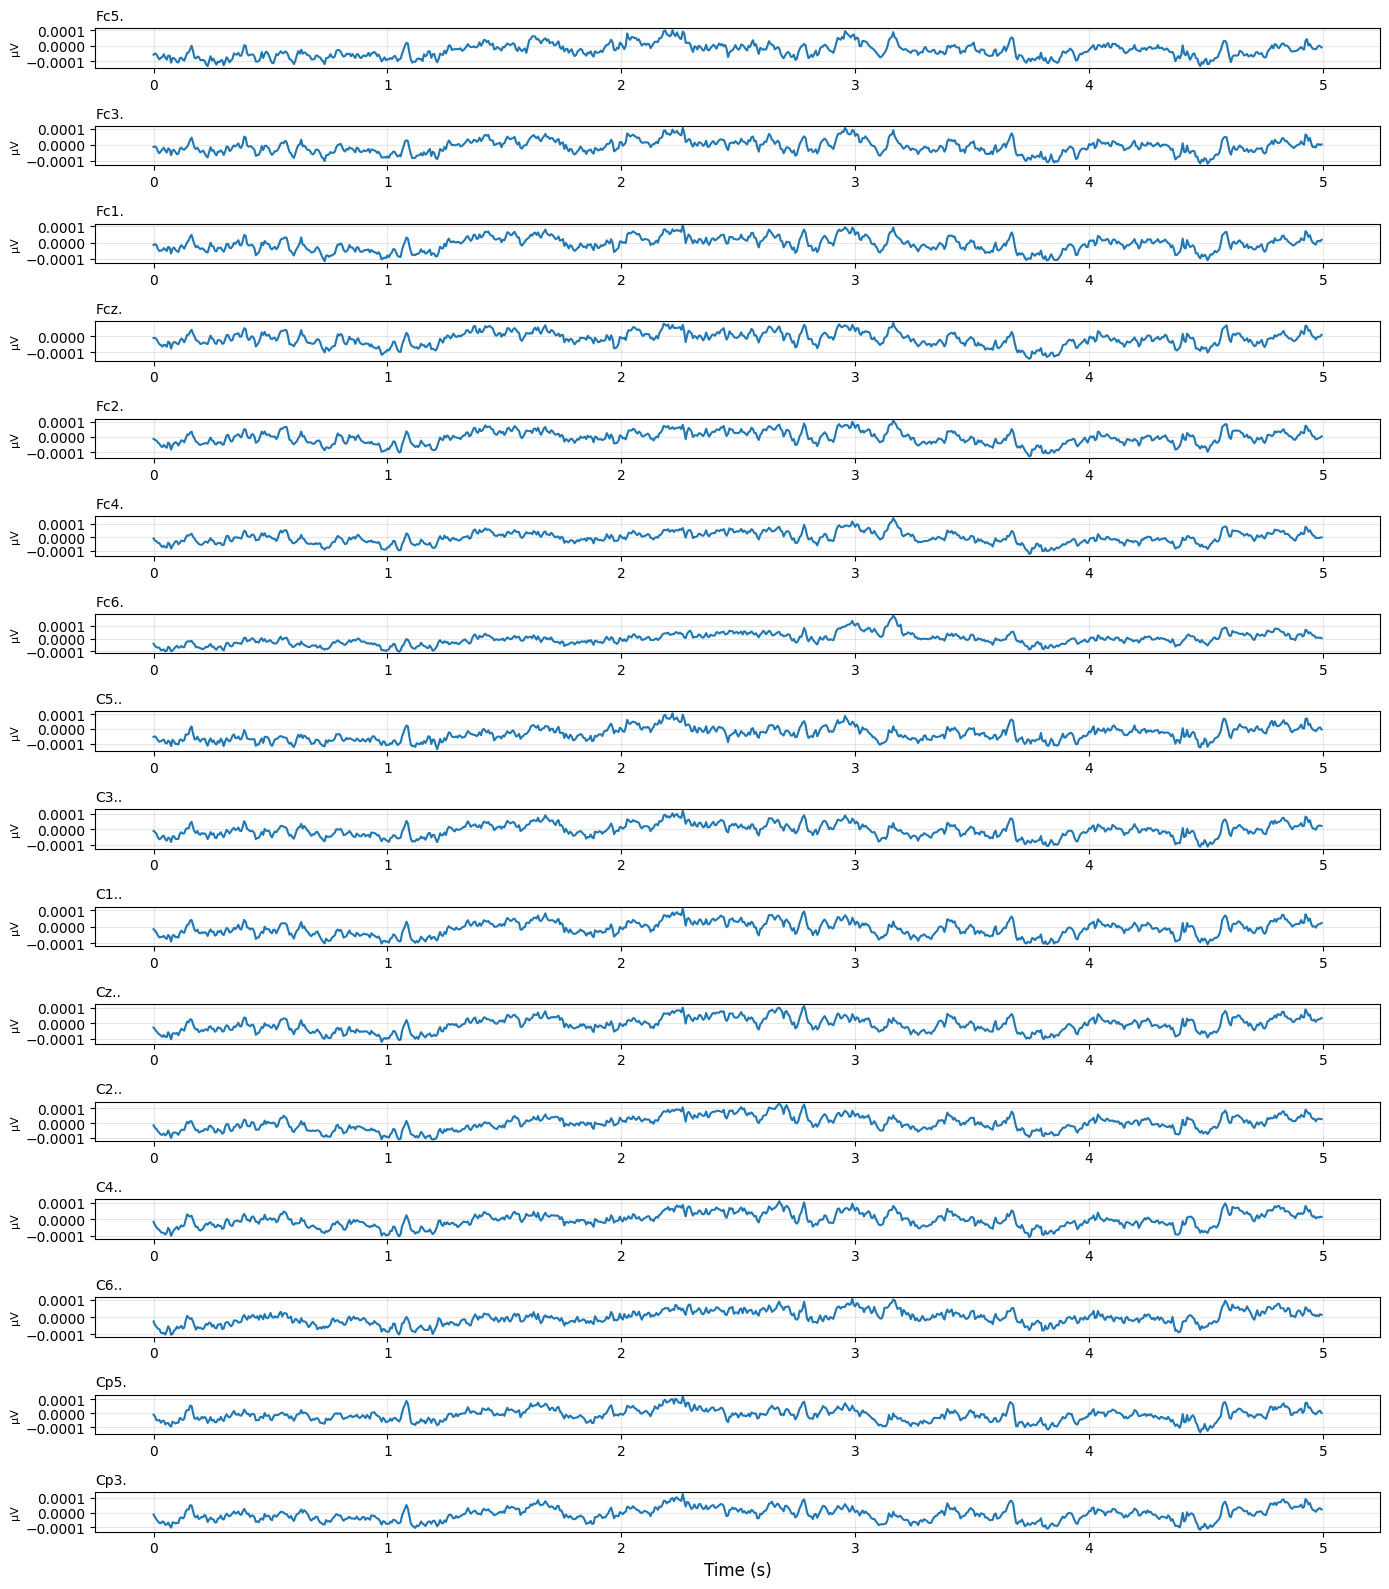

In [13]:

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 16))

for i, ch in enumerate(selected_channels):
    ax = plt.subplot(num_channels_to_plot, 1, i + 1)
    plt.plot(times_plot, signals_plot[ch, :])
    plt.title(channel_names[ch], loc='left', fontsize=10)
    plt.ylabel('µV', fontsize=8)
    plt.grid(alpha=0.3)

plt.xlabel('Time (s)', fontsize=12)
plt.tight_layout()
plt.show()

In [14]:
print(raw.info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>


In [15]:
#data regu;ation and visualization (Montage !)

In [16]:
eegbci.standardize(raw) 

In [17]:
from mne.channels import make_standard_montage
montage = make_standard_montage("standard_1005")
raw.set_montage(montage, on_missing="ignore")

print("Montage set correctly:")
print(raw.info)

Montage set correctly:
<Info | 8 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>


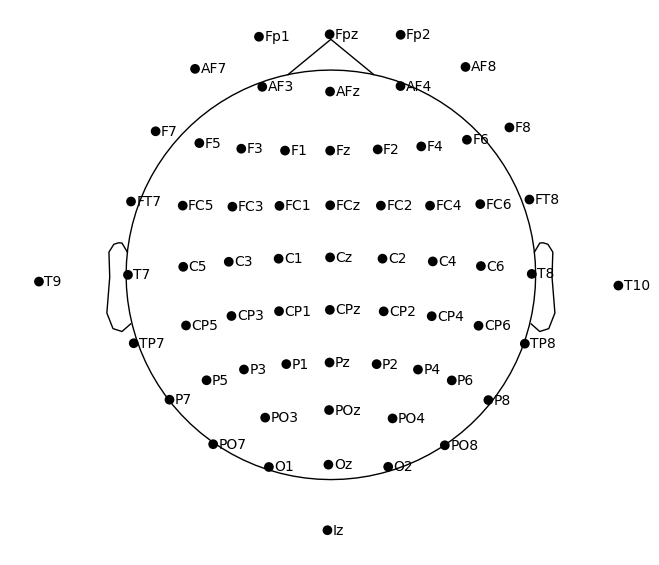

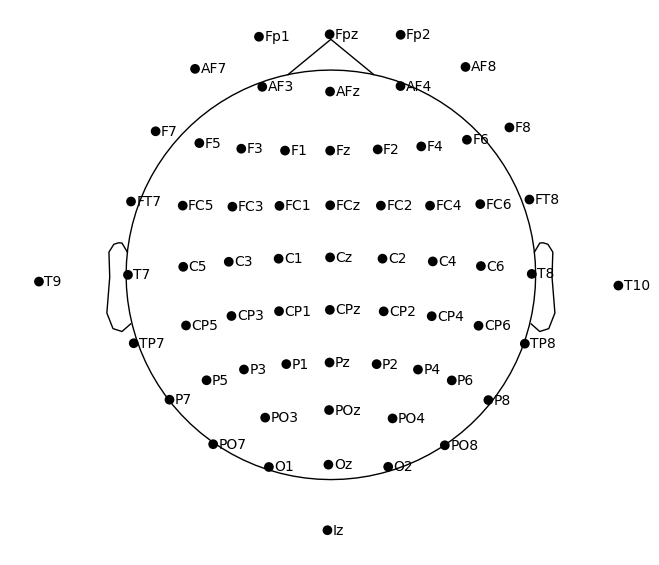

In [18]:
raw.plot_sensors(show_names=True, sphere='auto')

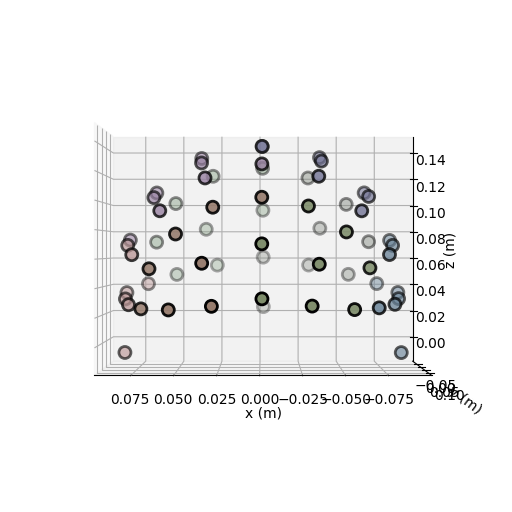

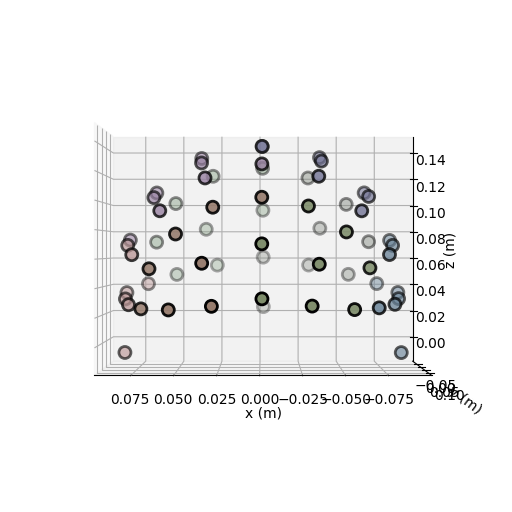

In [19]:

raw.plot_sensors(kind='3d', ch_type='eeg', ch_groups='position')

In [20]:
# Temporal Filtering (band pass filt here)
raw_filt = raw.copy().filter(
    l_freq=7.,
    h_freq=30.,
    fir_design='firwin',
    picks='eeg',
    skip_by_annotation='edge'
)


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [21]:
raw_filt.info

<Info | 8 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 7.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>

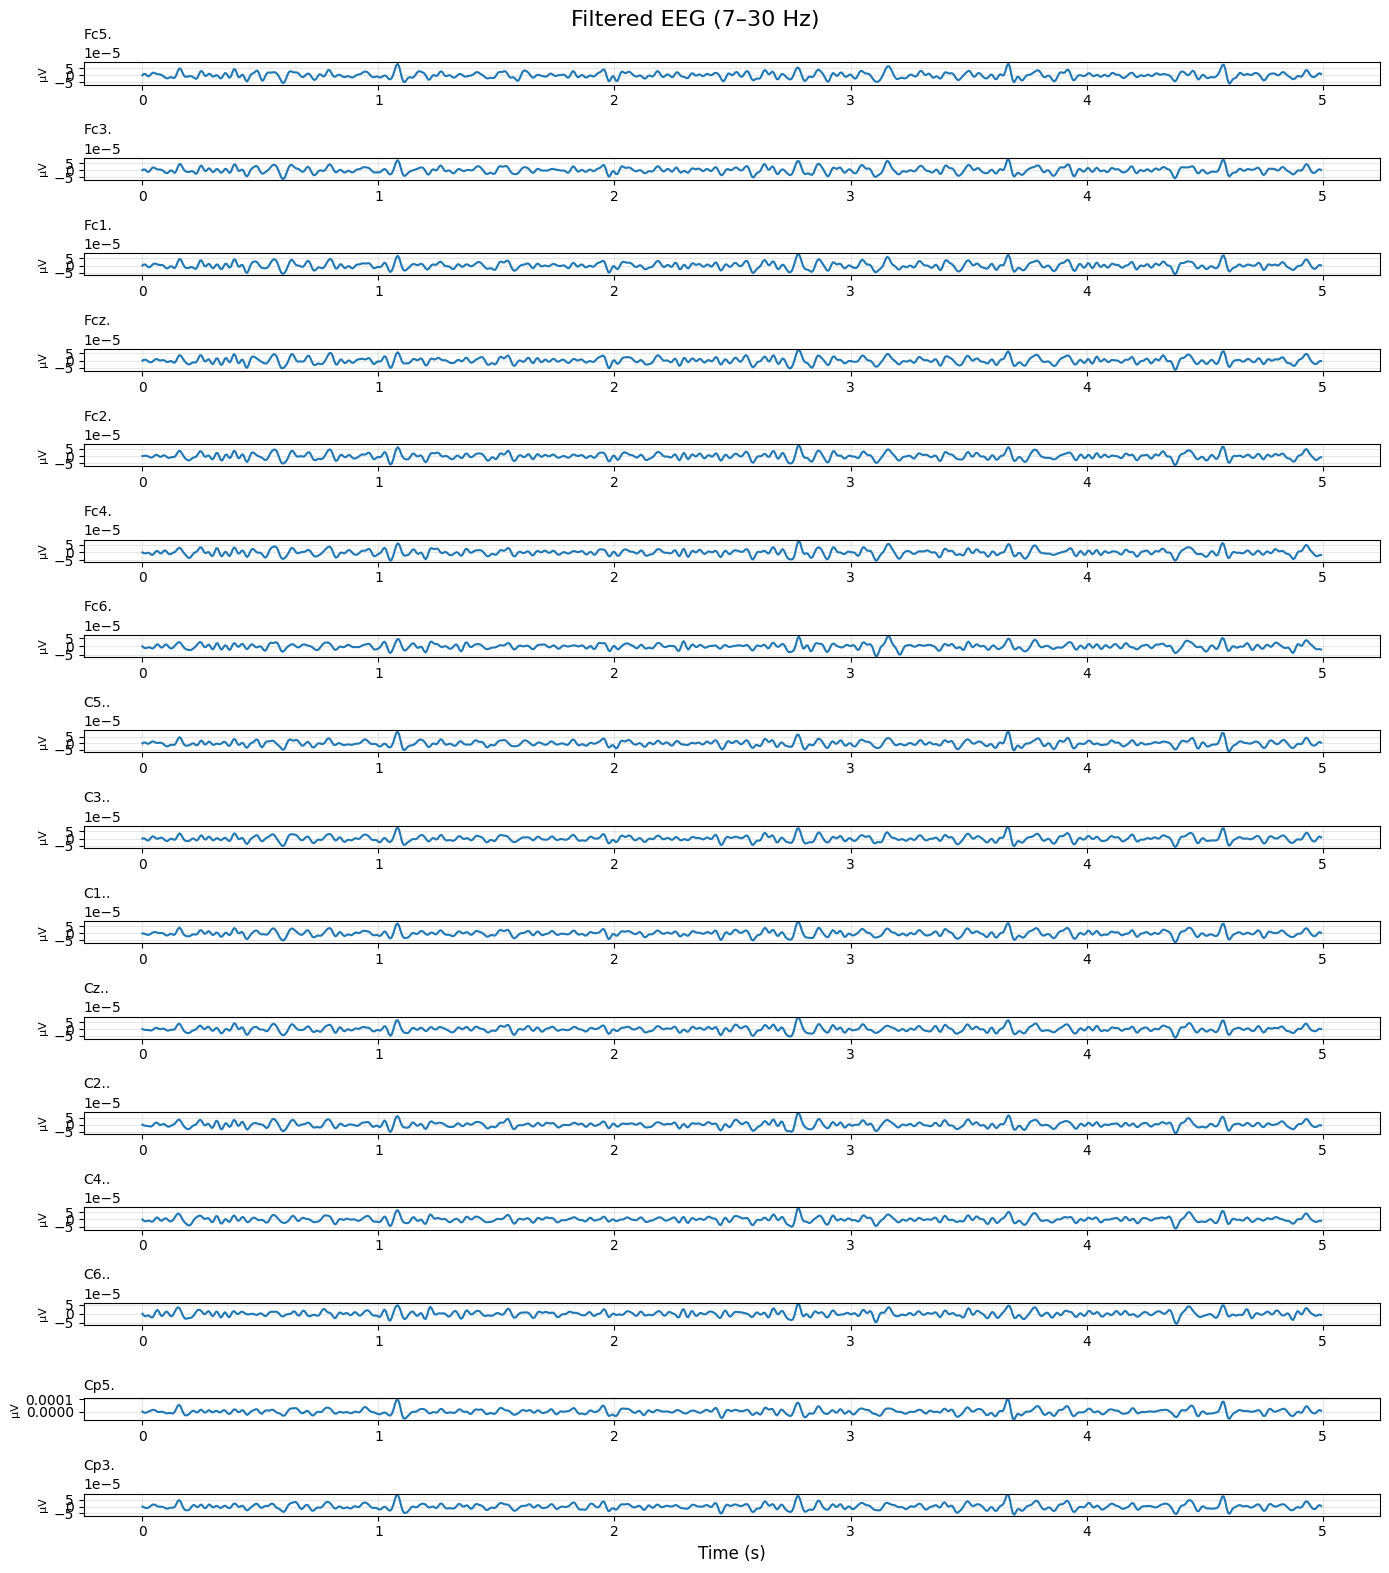

In [22]:
# AFTER FILTERING
signals_filt = raw_filt.get_data()[:, :num_samples]
times_filt = raw_filt.times[:num_samples]

plt.figure(figsize=(14, 16))
plt.suptitle("Filtered EEG (7–30 Hz)", fontsize=16)

for i, ch in enumerate(selected_channels):
    plt.subplot(num_channels_to_plot, 1, i + 1)
    plt.plot(times_filt, signals_filt[ch, :])
    plt.title(channel_names[ch], loc='left', fontsize=10)
    plt.ylabel('µV', fontsize=8)
    plt.grid(alpha=0.3)

plt.xlabel("Time (s)", fontsize=12)
plt.tight_layout()
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


/Users/chanok/Library/Python/3.11/lib/python/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


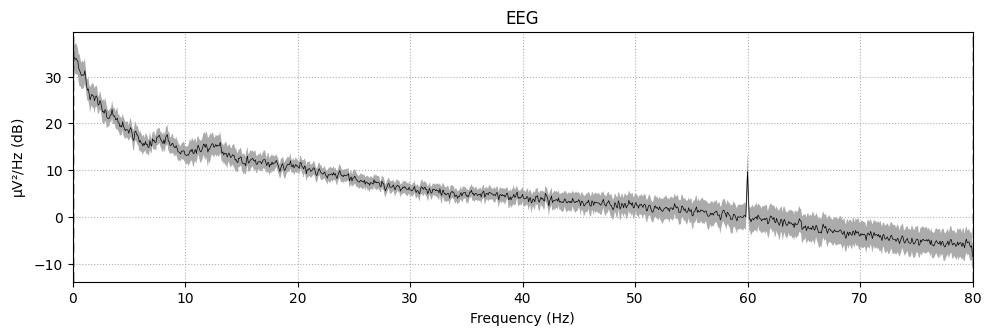

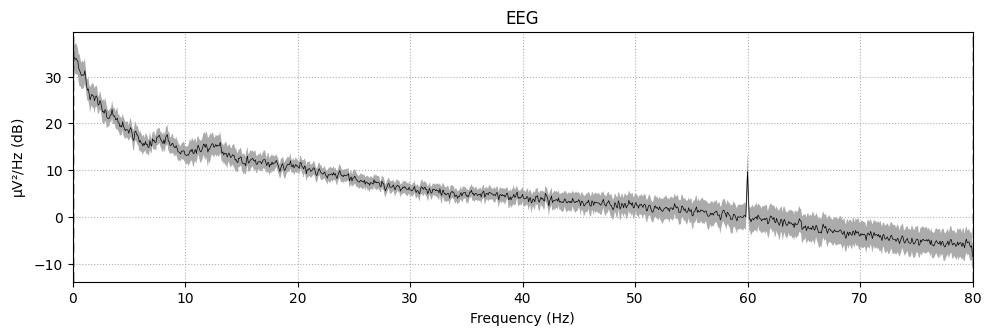

In [23]:
# BEFORE FILTERING
raw.plot_psd(fmax=80, average=True)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


/Users/chanok/Library/Python/3.11/lib/python/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


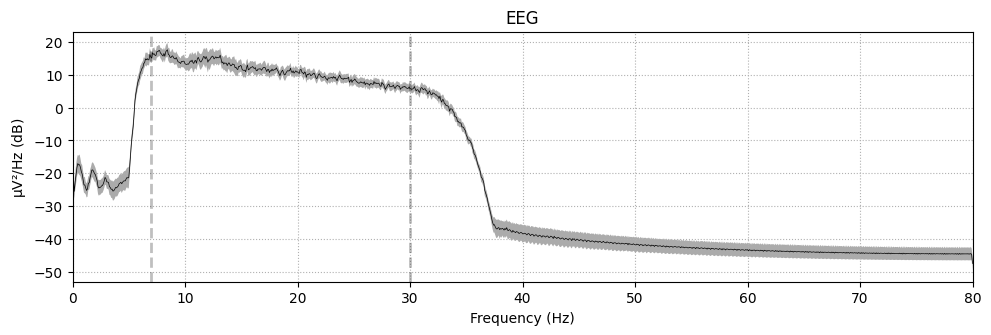

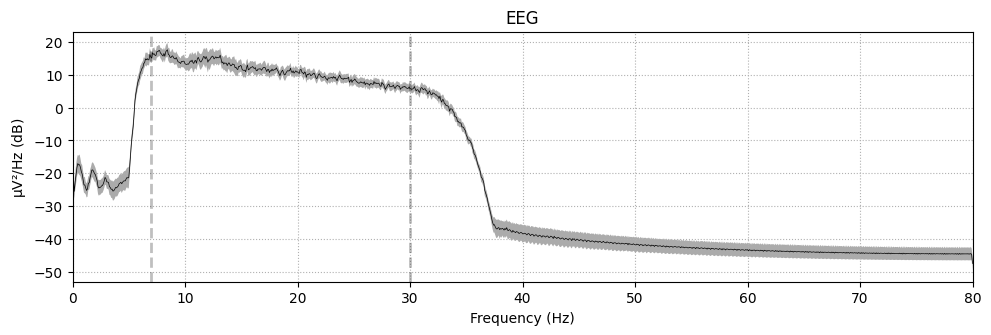

In [24]:
# AFTER FILTERING
raw_filt.plot_psd(fmax=80, average=True) 

NOTE: plot_psd_topo() is a legacy function. New code should use .compute_psd().plot_topo().
Effective window size : 12.800 (s)


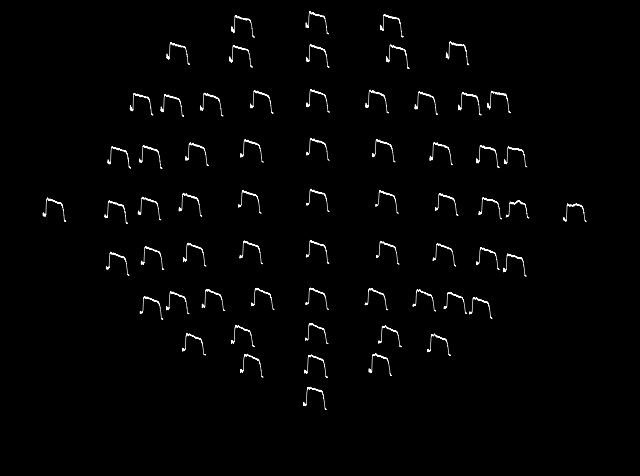

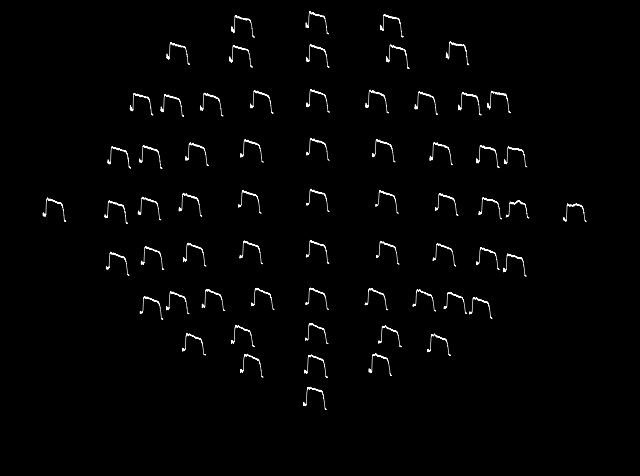

In [25]:
raw_filt.plot_psd_topo(fmax=40)

Effective window size : 12.800 (s)
converting legacy list-of-tuples input to a dict for the `bands` parameter


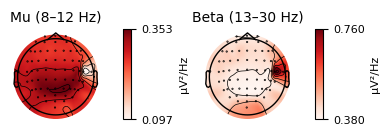

In [26]:
psd = raw_filt.compute_psd(fmin=2, fmax=40, picks="eeg")  # wider band, topomap will slice bands

# Define bands for topomap
bands = [
    (8., 12., "Mu (8–12 Hz)"),
    (13., 30., "Beta (13–30 Hz)"),
]

# Plot topographic maps of band power
fig = psd.plot_topomap(
    bands=bands,
    ch_type="eeg",
    normalize=True,   # normalize each map to highlight spatial pattern
)

#Mu power distribution over the scalp
#Beta power distribution over the scalp

<RawEDF | S001R03.edf, 9 x 60000 (375.0 s), ~4.2 MB, data loaded>
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


/var/folders/2p/kh1gl7sx22x19s6zqrtd4rj40000gn/T/ipykernel_89190/1628996054.py:5: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks_motor = mne.pick_channels(raw_filt.info["ch_names"], include=motor_channels)
/Users/chanok/Library/Python/3.11/lib/python/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


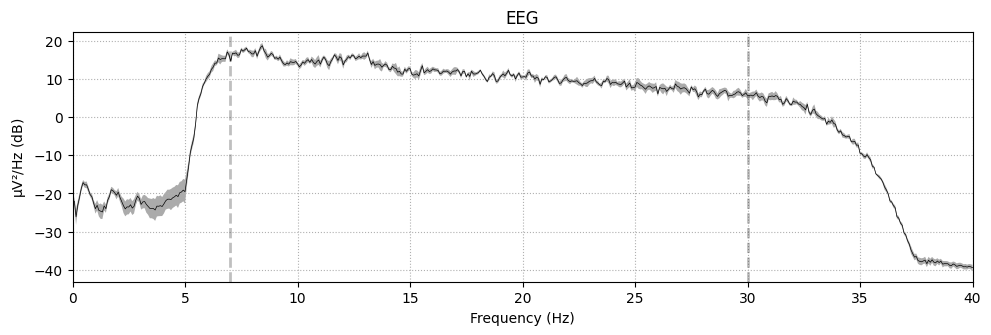

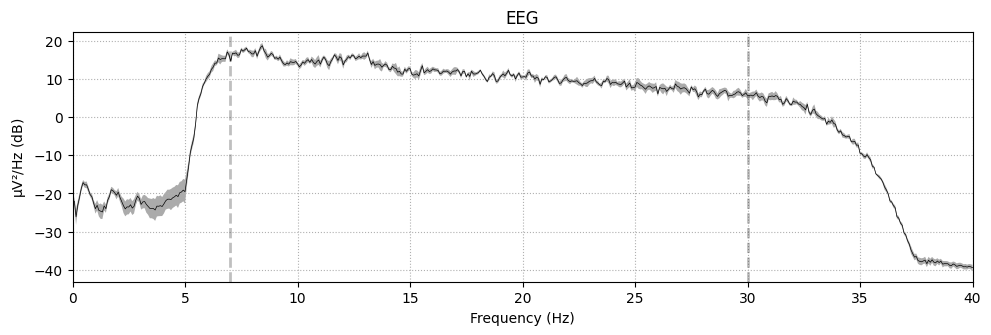

In [27]:
#cahnnel selection

motor_channels = ["C3", "Cz", "C4", "FC3", "FCz", "FC4", "CP3", "CPz", "CP4"]

picks_motor = mne.pick_channels(raw_filt.info["ch_names"], include=motor_channels)

raw_motor = raw_filt.copy().pick(picks_motor)
print(raw_motor)

#  PSD only for motor channels
raw_motor.plot_psd(fmax=40, average=True)

In [28]:
#Extract events
event_id = dict(left=1, right=2)  # we define our own codes

events, annot_event_id = mne.events_from_annotations(
    raw_filt,
    event_id=dict(T1=1, T2=2)   # T1 -> 1, T2 -> 2
)

print("Annotation event_id from MNE:", annot_event_id)
print("Events shape:", events.shape)
print("First 10 events:\n", events[:10])

Used Annotations descriptions: ['T1', 'T2']
Annotation event_id from MNE: {'T1': 1, 'T2': 2}
Events shape: (45, 3)
First 10 events:
 [[  672     0     2]
 [ 2000     0     1]
 [ 3328     0     1]
 [ 4656     0     2]
 [ 5984     0     2]
 [ 7312     0     1]
 [ 8640     0     1]
 [ 9968     0     2]
 [11296     0     1]
 [12624     0     2]]


In [29]:
labels = events[:, 2]  # third column = event code
print("Unique labels and counts:", np.unique(labels, return_counts=True))

Unique labels and counts: (array([1, 2]), array([23, 22]))


In [30]:
#Epoch
event_id = dict(left=1, right=2)  # we name the classes

# tmin = 1.0
# tmax = 3.0

tmin = 1.0
tmax = 4.0
epochs = mne.Epochs(
    raw_filt,
    events,
    event_id=event_id,   # {'left': 1, 'right': 2}
    tmin=tmin,
    tmax=tmax,
    picks=picks_motor,   # motor channels only
    baseline=None,
    preload=True
)

print(epochs)
print("Left trials:", len(epochs['left']))
print("Right trials:", len(epochs['right']))

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 481 original time points ...
0 bad epochs dropped
<Epochs |  45 events (all good), 1 – 4 s, baseline off, ~1.5 MB, data loaded,
 'left': 23
 'right': 22>
Left trials: 23
Right trials: 22


Using matplotlib as 2D backend.


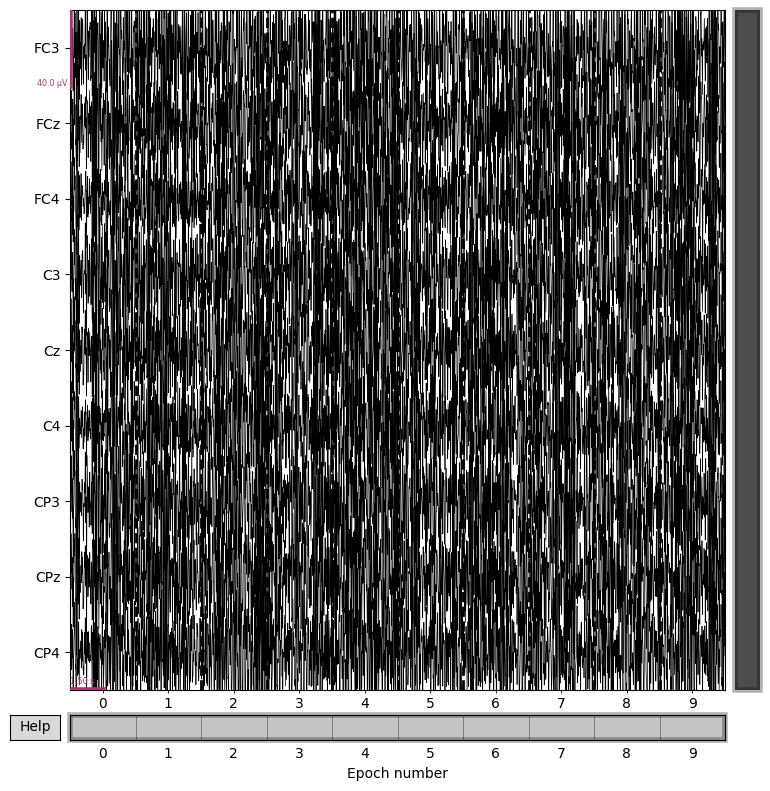

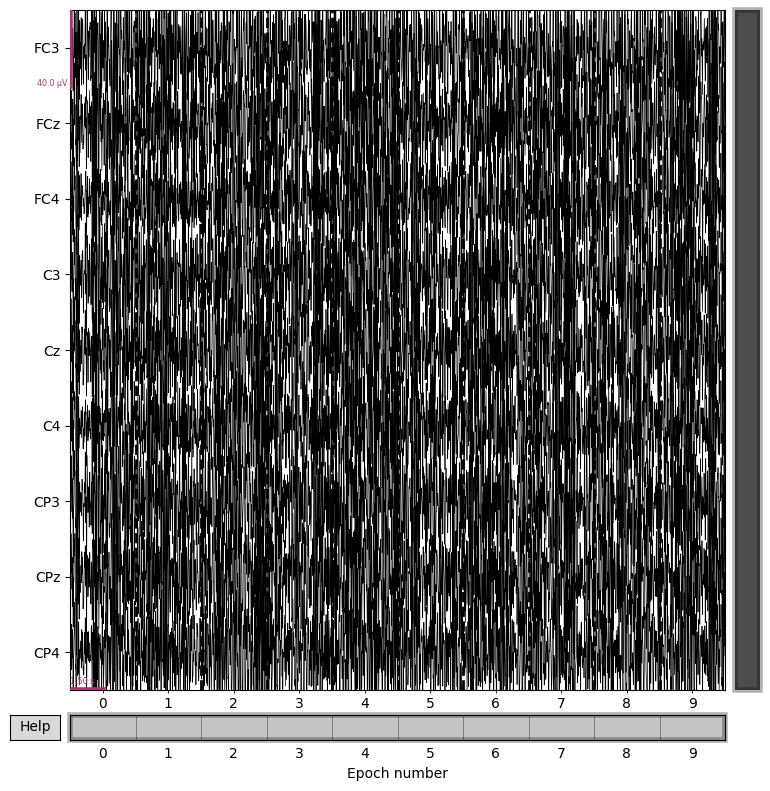

In [31]:
epochs[0:10].plot()

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/var/folders/2p/kh1gl7sx22x19s6zqrtd4rj40000gn/T/ipykernel_89190/467452149.py:3: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  psd_left.plot(average=True)
/Users/chanok/Library/Python/3.11/lib/python/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/var/folders/2p/kh1gl7sx22x19s6zqrtd4rj40000gn/T/ipykernel_89190/467452149.py:7: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  psd_right.plot(average=True)
/Users/chanok/Library/Python/3.11/lib/python/

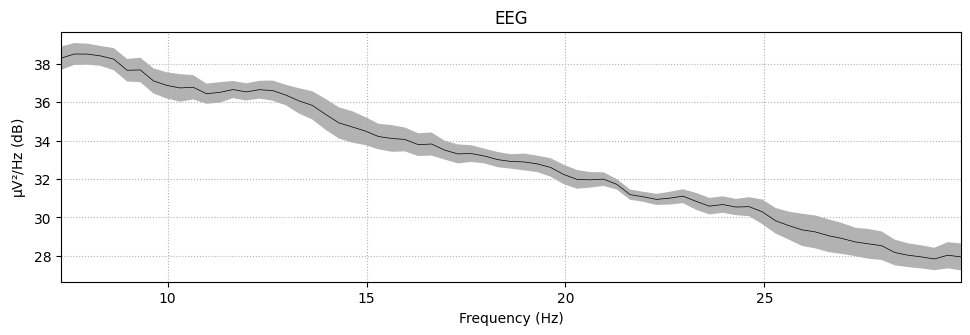

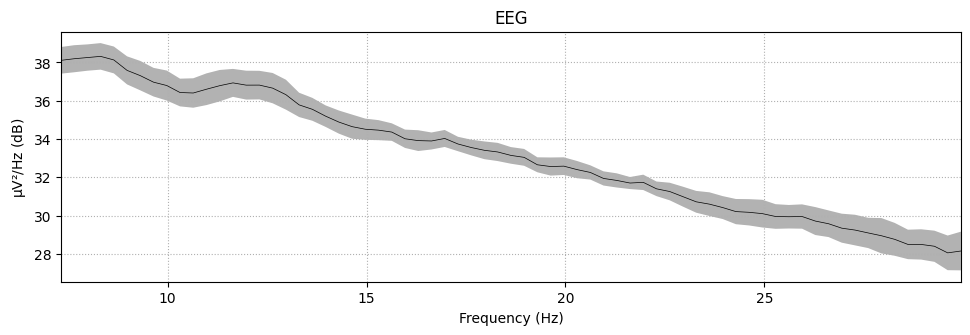

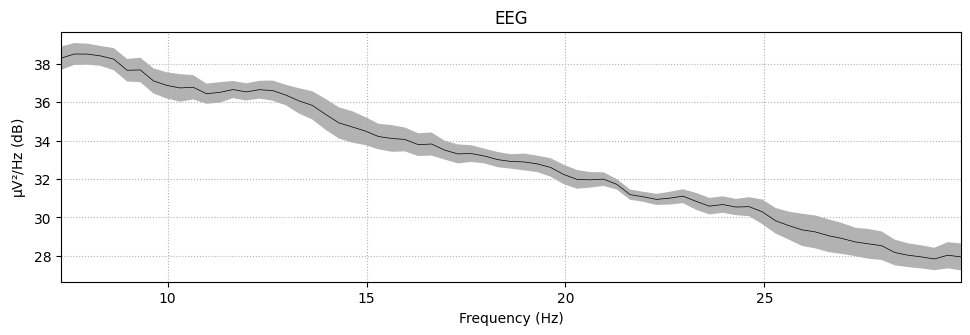

In [32]:
# LEFT trials PSD
psd_left = epochs['left'].compute_psd(fmin=7, fmax=30)
psd_left.plot(average=True)

# RIGHT trials PSD
psd_right = epochs['right'].compute_psd(fmin=7, fmax=30)
psd_right.plot(average=True)

In [33]:
#classification

In [34]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

from mne.decoding import CSP

from pyriemann.estimation import Covariances
from pyriemann.classification import MDM, TSclassifier


In [35]:
# ---------------------------------------------------------
# 1) Prepare data (X, y) from your epochs
# ---------------------------------------------------------
# epochs: your MNE Epochs object with event_id {'left':1, 'right':2}

# Data: (n_epochs, n_channels, n_times) in microvolts
epochs_data = 1e6 * epochs.get_data()

# Labels: 0 = left, 1 = right
y = epochs.events[:, 2]             # 1 = left, 2 = right
labels = (y == 2).astype(int)       # 0/1 for sklearn

print("Data shape:", epochs_data.shape)
print("Labels shape:", labels.shape)
print("Label counts:", np.unique(labels, return_counts=True))


Data shape: (45, 9, 481)
Labels shape: (45,)
Label counts: (array([0, 1]), array([23, 22]))


In [36]:
# 10-fold CV
cv = KFold(n_splits=10, shuffle=True, random_state=42)
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)

In [37]:
# 2) CSP + LDA
# ---------------------------------------------------------
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

clf_csp_lda = Pipeline([
    ('CSP', csp),
    ('LDA', lda),
])

scores_csp_lda = cross_val_score(
    clf_csp_lda,
    epochs_data,
    labels,
    cv=cv,
    n_jobs=1
)

print("\n=== CSP + LDA ===")
print("Accuracy: %.3f  | Chance: %.3f" % (scores_csp_lda.mean(), class_balance))


Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 9 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 9
    MAG: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 9 dim * 5.8e+15  max singular value)
    Estimated rank (mag): 9
    MAG: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 9 dim * 5.8e+15  max singular value)
    Estimated rank (mag): 9
    MAG: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 9 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 9
    MAG: ra

In [38]:
# 3) Riemannian MDM
# ---------------------------------------------------------
# Covariance matrices per epoch
cov_data = Covariances().transform(epochs_data)  # (n_epochs, n_channels, n_channels)

mdm = MDM(metric=dict(mean='riemann', distance='riemann'))

scores_mdm = cross_val_score(
    mdm,
    cov_data,
    labels,
    cv=cv,
    n_jobs=1
)

print("\n=== MDM (Riemann) ===")
print("Accuracy: %.3f  | Chance: %.3f" % (scores_mdm.mean(), class_balance))
# 3) Riemannian MDM
# ---------------------------------------------------------
# Covariance matrices per epoch
cov_data = Covariances().transform(epochs_data)  # (n_epochs, n_channels, n_channels)

mdm = MDM(metric=dict(mean='riemann', distance='riemann'))

scores_mdm = cross_val_score(
    mdm,
    cov_data,
    labels,
    cv=cv,
    n_jobs=1
)

print("\n=== MDM (Riemann) ===")
print("Accuracy: %.3f  | Chance: %.3f" % (scores_mdm.mean(), class_balance))



=== MDM (Riemann) ===
Accuracy: 0.660  | Chance: 0.511

=== MDM (Riemann) ===
Accuracy: 0.660  | Chance: 0.511


In [39]:
# 4) Tangent Space + Logistic Regression (TSclassifier)

tsc = TSclassifier()  # internally: Riemannian mean -> tangent space -> LR

scores_tsc = cross_val_score(
    tsc,
    cov_data,
    labels,
    cv=cv,
    n_jobs=1
)

print("\n=== Tangent Space + LR (TSclassifier) ===")
print("Accuracy: %.3f  | Chance: %.3f" % (scores_tsc.mean(), class_balance))



=== Tangent Space + LR (TSclassifier) ===
Accuracy: 0.635  | Chance: 0.511


Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 9 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 9
    MAG: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 9 dim * 6e+15  max singular value)
    Estimated rank (mag): 9
    MAG: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating covariance using EMPIRICAL
Done.


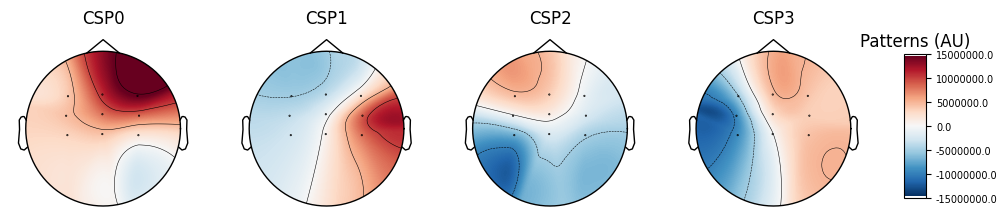

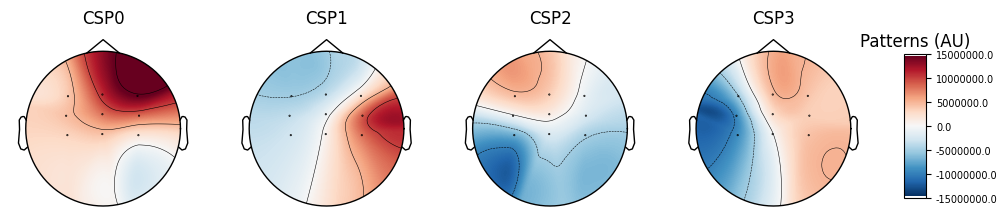

In [40]:
# 5) Fit CSP on all data and plot spatial patterns
clf_csp_lda.fit(epochs_data, labels)
csp = clf_csp_lda.named_steps['CSP']

csp.plot_patterns(
    epochs.info,
    ch_type='eeg',
    units='Patterns (AU)',
    size=1.5
)

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from mne.decoding import CSP

from pyriemann.estimation import Covariances
from pyriemann.classification import MDM, TSclassifier


# 1. Helper: prepare data from an MNE Epochs object
#    Assumes event_id = {'left': 1, 'right': 2}

def prepare_data_from_epochs(epochs):
    """
    epochs: MNE Epochs object with left/right MI trials.
    Returns:
        epochs_data : (n_epochs, n_channels, n_times) in µV
        labels      : (n_epochs,) binary labels 0/1 (0=left, 1=right)
        info        : epochs.info (for plotting)
        class_names : ['left', 'right']
    """
    # Data in microvolts
    epochs_data = 1e6 * epochs.get_data()  # (trials, channels, times)

    # Labels from events: 1 = left, 2 = right
    y_raw = epochs.events[:, 2]
    # Map to 0/1: 0 = left, 1 = right
    labels = (y_raw == 2).astype(int)

    print("Data shape (epochs, channels, times):", epochs_data.shape)
    print("Labels (0=left,1=right):", np.unique(labels, return_counts=True))

    return epochs_data, labels, epochs.info, ['left', 'right']



# 2. Main evaluation: run all classical models with K-fold CV

def evaluate_classical_models(epochs, n_splits=10, random_state=42):
    """
    Run CSP+LDA, CSP+LogReg, MDM, TSclassifier with 10-fold CV.
    Returns:
        results_df : pandas DataFrame with mean accuracy per model
        extras     : dict with objects for further plotting (CSP, mdm, tsc, cov_data, epochs_data, labels, info)
    """
    epochs_data, labels, info, class_names = prepare_data_from_epochs(epochs)

    # 10-fold CV
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Chance level from class balance
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)

    # Model 1: CSP + LDA
    lda = LinearDiscriminantAnalysis()
    csp_lda = CSP(n_components=4, reg=None, log=True, norm_trace=False)

    pipe_csp_lda = Pipeline([
        ('CSP', csp_lda),
        ('LDA', lda),
    ])

    scores_csp_lda = cross_val_score(
        pipe_csp_lda, epochs_data, labels, cv=cv, n_jobs=1
    )


    # Model 2: CSP + Logistic Regression

    logreg = LogisticRegression(max_iter=1000)
    csp_lr = CSP(n_components=4, reg=None, log=True, norm_trace=False)

    pipe_csp_lr = Pipeline([
        ('CSP', csp_lr),
        ('LogReg', logreg),
    ])

    scores_csp_lr = cross_val_score(
        pipe_csp_lr, epochs_data, labels, cv=cv, n_jobs=1
    )

    # Riemannian: covariance matrices
    cov_data = Covariances().transform(epochs_data)  # (epochs, ch, ch)

    # Model 3: MDM (Riemannian)

    mdm = MDM(metric=dict(mean='riemann', distance='riemann'))

    scores_mdm = cross_val_score(
        mdm, cov_data, labels, cv=cv, n_jobs=1
    )

    # Model 4: Tangent Space + LR (TSclassifier)

    tsc = TSclassifier()  # internally does tangent-space + LR

    scores_tsc = cross_val_score(
        tsc, cov_data, labels, cv=cv, n_jobs=1
    )

    results = {
        'Model': [
            'CSP + LDA',
            'CSP + LogReg',
            'MDM (Riemann)',
            'TSclassifier (Tangent Space + LR)'
        ],
        'Mean_Accuracy': [
            scores_csp_lda.mean(),
            scores_csp_lr.mean(),
            scores_mdm.mean(),
            scores_tsc.mean()
        ],
        'Std_Accuracy': [
            scores_csp_lda.std(),
            scores_csp_lr.std(),
            scores_mdm.std(),
            scores_tsc.std()
        ],
        'Chance_Level': [class_balance]*4
    }

    results_df = pd.DataFrame(results)

    print("\n=== Cross-validated accuracies ({}-fold) ===".format(n_splits))
    print(results_df)

    # Fit CSP and Riemann models on full data for plotting

    pipe_csp_lda.fit(epochs_data, labels)
    csp_full = pipe_csp_lda.named_steps['CSP']

    mdm_full = MDM(metric=dict(mean='riemann', distance='riemann'))
    mdm_full.fit(cov_data, labels)

    tsc_full = TSclassifier()
    tsc_full.fit(cov_data, labels)

    extras = {
        'epochs_data': epochs_data,
        'labels': labels,
        'info': info,
        'class_names': class_names,
        'csp_full': csp_full,
        'mdm_full': mdm_full,
        'tsc_full': tsc_full,
        'cov_data': cov_data,
        'chance_level': class_balance,
        'results_df': results_df,
    }

    return results_df, extras


def plot_csp_patterns(extras, n_components=4):
    """
    Plot CSP spatial patterns learned on full data.
    extras: dict returned by evaluate_classical_models()
    """
    csp_full = extras['csp_full']
    info = extras['info']

    print("\nPlotting CSP patterns...")
    csp_full.plot_patterns(
        info,
        ch_type='eeg',
        components=list(range(n_components)),
        units='Patterns (AU)',
        size=1.5
    )

def plot_riemann_centroids(extras):
    """
    Visualize Riemannian mean covariances per class as heatmaps.
    """
    mdm_full = extras['mdm_full']
    covmeans = mdm_full.covmeans_       # shape (n_classes, n_channels, n_channels)
    ch_names = extras['info'].ch_names
    class_names = extras['class_names']

    n_classes = len(covmeans)
    fig, axes = plt.subplots(1, n_classes, figsize=(4*n_classes, 4))

    if n_classes == 1:
        axes = [axes]

    for idx in range(n_classes):
        df = pd.DataFrame(
            data=covmeans[idx],
            index=ch_names,
            columns=ch_names
        )
        ax = axes[idx]
        g = sns.heatmap(
            df,
            ax=ax,
            square=True,
            cbar=False,
            xticklabels=2,
            yticklabels=2
        )
        g.set_title(f"Mean covariance - {class_names[idx]}")
        plt.sca(ax)
        plt.xticks(rotation='vertical')
        plt.yticks(rotation='horizontal')

    plt.tight_layout()
    plt.show()



Data shape (epochs, channels, times): (45, 9, 481)
Labels (0=left,1=right): (array([0, 1]), array([23, 22]))
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 9 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 9
    MAG: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 9 dim * 5.8e+15  max singular value)
    Estimated rank (mag): 9
    MAG: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 9 dim * 5.8e+15  max singular value)
    Estimated rank (mag): 9
    MAG: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    U

Reducing data rank from 9 -> 9
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 9 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 9
    MAG: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 9 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 9
    MAG: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 9 dim * 6e+15  max singular value)
    Estimated rank (mag): 9
    MAG: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 9 d

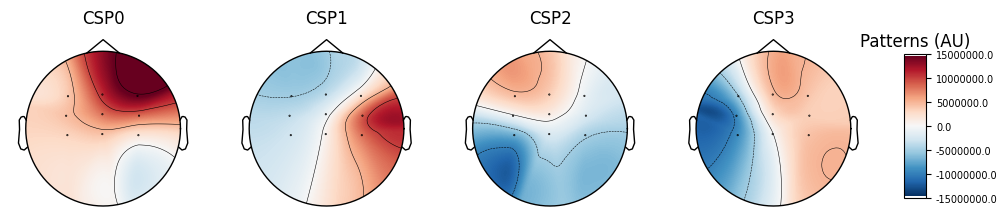

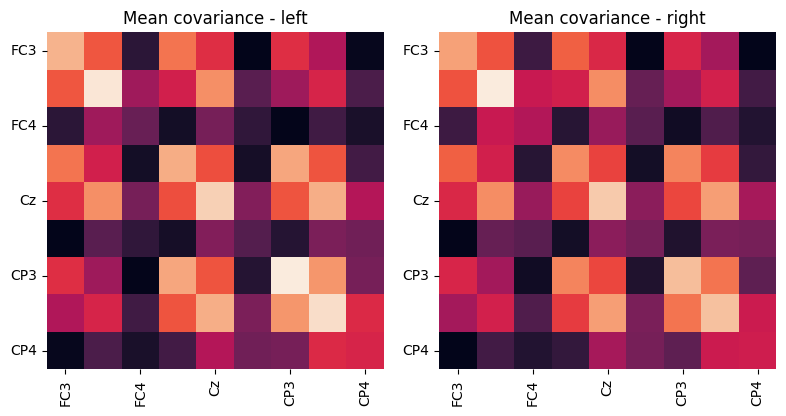

In [42]:

results_df, extras = evaluate_classical_models(epochs, n_splits=10)

plot_csp_patterns(extras, n_components=4)
plot_riemann_centroids(extras)

In [43]:
#eegnet

# 1) Get data from epochs (Volts -> microvolts)
X = 1e6 * epochs.get_data()               # (n_trials, n_channels, n_times)
y = epochs.events[:, 2]                   # 1 = left, 2 = right

# 2) Binary labels: 0 = left, 1 = right
y_bin = (y == 2).astype(int)

print("X raw shape:", X.shape)
print("Label counts:", np.unique(y_bin, return_counts=True))

# 3) Reorder axes to (n_trials, n_times, n_channels)
X = np.transpose(X, (0, 2, 1))           # (trials, times, channels)

# 4) Add last dimension for CNN
X = X[..., np.newaxis]                   # (trials, times, channels, 1)

print("X for EEGNet:", X.shape)

X raw shape: (45, 9, 481)
Label counts: (array([0, 1]), array([23, 22]))
X for EEGNet: (45, 481, 9, 1)


In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin,
    test_size=0.3,
    random_state=42,
    stratify=y_bin,
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (31, 481, 9, 1) Test: (14, 481, 9, 1)


In [45]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D,
                                     BatchNormalization, Activation, AveragePooling2D,
                                     Dropout, Flatten, Dense)
from tensorflow.keras.models import Model

def build_eegnet(n_times, n_channels,
                 F1=8, D=2, F2=16,
                 kern_length=64,
                 dropout_rate=0.5):
    """
    n_times: number of time samples in each epoch
    n_channels: number of EEG channels
    """

    # Input: (time, channels, 1)
    inp = Input(shape=(n_times, n_channels, 1))


    # Block 1: Temporal convolution

    x = Conv2D(
        filters=F1,
        kernel_size=(kern_length, 1),
        padding='same',
        use_bias=False
    )(inp)
    x = BatchNormalization()(x)

   
    # Block 2: Depthwise spatial convolution (across channels)

    x = DepthwiseConv2D(
        (1, n_channels),
        use_bias=False,
        depth_multiplier=D,
        padding='valid'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # Pool along time
    x = AveragePooling2D((4, 1))(x)
    x = Dropout(dropout_rate)(x)

    # Block 3: Separable conv (temporal)
    x = SeparableConv2D(
        F2,
        kernel_size=(16, 1),
        padding='same',
        use_bias=False
    )(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = AveragePooling2D((8, 1))(x)
    x = Dropout(dropout_rate)(x)

    # Classification
   
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)   # binary classification

    model = Model(inputs=inp, outputs=out)
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model

# Build model using your data shape
n_times = X_train.shape[1]
n_channels = X_train.shape[2]

model = build_eegnet(n_times, n_channels)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 481, 9, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 481, 9, 8)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 481, 9, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 481, 1, 16)     │           144 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 481, 1, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 481, 1, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 120, 1, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 1, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 120, 1, 16)     │           512 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 120, 1, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 120, 1, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 15, 1, 16)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 1, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 240)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           241 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,569 (6.13 KB)

 Trainable params: 1,489 (5.82 KB)

 Non-trainable params: 80 (320.00 B)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,           # stop if no improvement for 20 epochs
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    batch_size=8,          # small batch: few trials
    epochs=200,
    validation_split=0.25, # small validation set from train
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4783 - loss: 0.7499 - val_accuracy: 0.6250 - val_loss: 0.7132
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3913 - loss: 0.7661 - val_accuracy: 0.6250 - val_loss: 0.7090
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5217 - loss: 0.7718 - val_accuracy: 0.6250 - val_loss: 0.7061
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4783 - loss: 0.6918 - val_accuracy: 0.6250 - val_loss: 0.7035
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4348 - loss: 0.7552 - val_accuracy: 0.6250 - val_loss: 0.7010
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6957 - loss: 0.7114 - val_accuracy: 0.6250 - val_loss: 0.6993
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6087 - loss: 0.6471 - val_accuracy: 0.6250 - val_loss: 0.6983
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6522 - loss: 0.6689 - val_accuracy: 0.6250 - val_loss:

Epoch 52/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8261 - loss: 0.5239 - val_accuracy: 0.6250 - val_loss: 0.6698
Epoch 53/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8696 - loss: 0.4406 - val_accuracy: 0.6250 - val_loss: 0.6696
Epoch 54/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7826 - loss: 0.4738 - val_accuracy: 0.6250 - val_loss: 0.6691
Epoch 55/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7826 - loss: 0.5075 - val_accuracy: 0.6250 - val_loss: 0.6685
Epoch 56/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7826 - loss: 0.5013 - val_accuracy: 0.6250 - val_loss: 0.6680
Epoch 57/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8261 - loss: 0.5037 - val_accuracy: 0.6250 - val_loss: 0.6678
Epoch 58/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7391 - loss: 0.4819 - val_accuracy: 0.6250 - val_loss: 0.6680
Epoch 59/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9130 - loss: 0.4330 - val_accuracy: 0.7500 - v

In [47]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"EEGNet Test accuracy: {test_acc:.3f}")

EEGNet Test accuracy: 0.214


# feet and hand

In [48]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf
from mne.channels import make_standard_montage
from mne import Epochs, events_from_annotations

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from mne.decoding import CSP

In [49]:
# Choose subject and runs for HANDS vs FEET motor imagery
subject = 1
runs = [6, 10, 14]   # motor imagery: both hands vs both feet

# Download / locate EDF files
raw_fnames = eegbci.load_data(subject, runs)

# Load and concatenate runs
raw_list = [read_raw_edf(f, preload=True) for f in raw_fnames]
raw = mne.concatenate_raws(raw_list)

print(raw)

Download complete in 01s (7.4 MB)
Extracting EDF parameters from /Users/chanok/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/chanok/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/chanok/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.3 MB, data loaded>


In [50]:
# Standardize EEG channel names (EEG 001 -> e.g. Fz, Cz, ...)
eegbci.standardize(raw)

# Set 10-20 montage so channels have 3D positions
montage = make_standard_montage('standard_1020')
raw.set_montage(montage)

# Band-pass filter in motor imagery band (mu+beta)
raw.filter(7., 30., fir_design='firwin')

# Optional: notch filter to remove line noise
raw.notch_filter(60.)

print(raw.info['ch_names'])

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edg

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [51]:
from mne import pick_types

# Pick only EEG channels
picks = pick_types(raw.info,
                   meg=False,
                   eeg=True,
                   stim=False,
                   eog=False,
                   exclude='bads')

# Optional: subsample electrodes (e.g., odd-indexed) to reduce dimensionality
# picks = picks[::2]

print("Number of EEG channels used:", len(picks))

Number of EEG channels used: 64


In [52]:
# Define event mapping: hands vs feet
event_id = dict(hands=2, feet=3)

# Get events from annotations: map T1 -> 2, T2 -> 3
events, annot_event_id = events_from_annotations(
    raw,
    event_id=dict(T1=2, T2=3)
)

print("Annotation event_id mapping:", annot_event_id)
print("Events shape:", events.shape)
print("First 10 events:\n", events[:10])

Used Annotations descriptions: ['T1', 'T2']
Annotation event_id mapping: {'T1': 2, 'T2': 3}
Events shape: (45, 3)
First 10 events:
 [[  672     0     3]
 [ 2000     0     2]
 [ 3328     0     2]
 [ 4656     0     3]
 [ 5984     0     2]
 [ 7312     0     3]
 [ 8640     0     3]
 [ 9968     0     2]
 [11296     0     2]
 [12624     0     3]]


In [60]:
tmin, tmax = 1.0, 3.0  # seconds relative to cue onset

epochs = Epochs(
    raw,
    events,
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True
)

print(epochs)
print("Hands trials:", len(epochs['hands']))
print("Feet trials:", len(epochs['feet']))

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped
<Epochs |  45 events (all good), 1 – 3 s, baseline off, ~7.1 MB, data loaded,
 'hands': 21
 'feet': 24>
Hands trials: 21
Feet trials: 24


In [61]:
# Data in microvolts
epochs_data = 1e6 * epochs.get_data()   # (trials, channels, times)

# Labels: hands=0, feet=1
# epochs.events[:, -1] is 2 for hands, 3 for feet
labels = epochs.events[:, -1] - 2       # 0 = hands, 1 = feet

print("Data shape:", epochs_data.shape)
print("Labels (0=hands,1=feet):", np.unique(labels, return_counts=True))

Data shape: (45, 64, 321)
Labels (0=hands,1=feet): (array([0, 1]), array([21, 24]))


In [62]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Compute chance level from class balance
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Chance level (class balance):", class_balance)

Chance level (class balance): 0.5333333333333333


In [63]:
# Assemble CSP + LDA classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(
    n_components=4,
    reg=None,
    log=True,
    norm_trace=False
)

clf = Pipeline([
    ('CSP', csp),
    ('LDA', lda),
])

# Cross-validated accuracy
scores = cross_val_score(
    clf,
    epochs_data,
    labels,
    cv=cv,
    n_jobs=1
)

print("\nCSP + LDA Classification accuracy: %.3f ± %.3f  | Chance: %.3f"
      % (scores.mean(), scores.std(), class_balance))

Computing rank from data with rank=None
    Using tolerance 1.6e+02 (2.2e-16 eps * 64 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e+02 (2.2e-16 eps * 64 dim * 1e+16  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e+02 (2.2e-16 eps * 64 dim * 9.8e+15  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+02 (2.2e-16 eps * 64 dim * 1.1e+16  max singular value)
  

Computing rank from data with rank=None
    Using tolerance 1.3e+02 (2.2e-16 eps * 64 dim * 8.8e+15  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e+02 (2.2e-16 eps * 64 dim * 7.9e+15  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


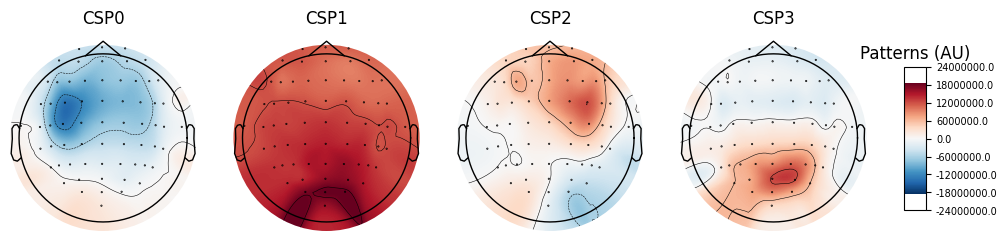

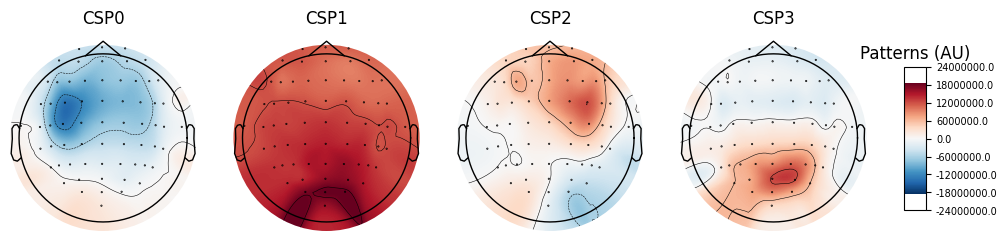

In [57]:
# Fit on all data (for visualization)
clf.fit(epochs_data, labels)
csp_full = clf.named_steps['CSP']

# Plot first few CSP patterns
csp_full.plot_patterns(
    epochs.info,
    ch_type='eeg',
    units='Patterns (AU)',
    size=1.5
)

In [64]:
from pyriemann.estimation import Covariances
from pyriemann.classification import MDM, TSclassifier

# Covariance matrices per epoch
cov_data = Covariances().transform(epochs_data)

# MDM
mdm = MDM(metric=dict(mean='riemann', distance='riemann'))
scores_mdm = cross_val_score(mdm, cov_data, labels, cv=cv, n_jobs=1)
print("MDM Accuracy: %.3f ± %.3f  | Chance: %.3f"
      % (scores_mdm.mean(), scores_mdm.std(), class_balance))

# Tangent Space + Logistic Regression
tsc = TSclassifier()
scores_tsc = cross_val_score(tsc, cov_data, labels, cv=cv, n_jobs=1)
print("TS-LR Accuracy: %.3f ± %.3f  | Chance: %.3f"
      % (scores_tsc.mean(), scores_tsc.std(), class_balance))

MDM Accuracy: 0.885 ± 0.161  | Chance: 0.533
TS-LR Accuracy: 0.925 ± 0.115  | Chance: 0.533


Chance level: 0.5333333333333333
Computing rank from data with rank=None
    Using tolerance 1.6e+02 (2.2e-16 eps * 64 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e+02 (2.2e-16 eps * 64 dim * 1e+16  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e+02 (2.2e-16 eps * 64 dim * 9.8e+15  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+02 (2.2e-16 eps * 64 dim 

Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+02 (2.2e-16 eps * 64 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e+02 (2.2e-16 eps * 64 dim * 1e+16  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+02 (2.2e-16 eps * 64 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Us

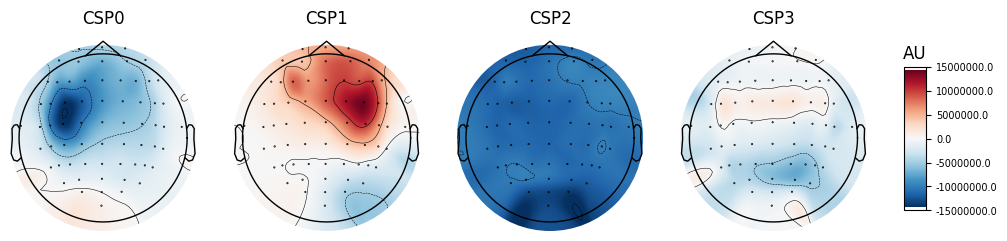

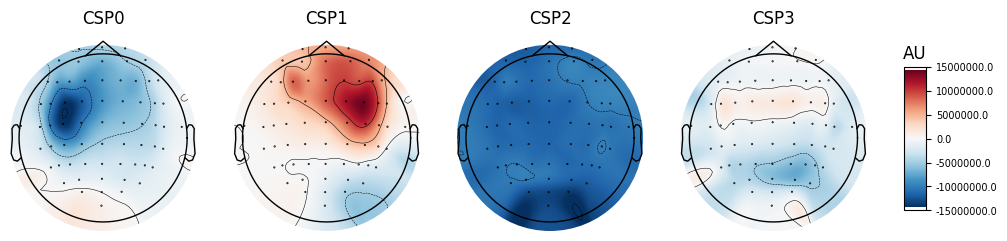

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from mne.decoding import CSP
from pyriemann.estimation import Covariances
from pyriemann.classification import MDM, TSclassifier

# 1) Cross-validation setup
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Class balance (chance level)
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Chance level:", class_balance)


# 2) CSP + LDA

lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

clf_csp_lda = Pipeline([
    ('CSP', csp),
    ('LDA', lda)
])

scores_csp_lda = cross_val_score(
    clf_csp_lda, epochs_data, labels, cv=cv, n_jobs=1
)

print("\n=== CSP + LDA ===")
print("Accuracy: %.3f  ± %.3f  | Chance: %.3f"
      % (scores_csp_lda.mean(), scores_csp_lda.std(), class_balance))


# 3) CSP + Logistic Regression 

logreg = LogisticRegression(max_iter=200)
clf_csp_lr = Pipeline([
    ('CSP', csp),
    ('LogReg', logreg)
])

scores_csp_lr = cross_val_score(
    clf_csp_lr, epochs_data, labels, cv=cv, n_jobs=1
)

print("\n=== CSP + Logistic Regression ===")
print("Accuracy: %.3f  ± %.3f  | Chance: %.3f"
      % (scores_csp_lr.mean(), scores_csp_lr.std(), class_balance))


# 4) Riemannian: MDM

cov_data = Covariances().transform(epochs_data)

mdm = MDM(metric=dict(mean='riemann', distance='riemann'))
scores_mdm = cross_val_score(
    mdm, cov_data, labels, cv=cv, n_jobs=1
)

print("\n=== MDM (Riemann) ===")
print("Accuracy: %.3f  ± %.3f  | Chance: %.3f"
      % (scores_mdm.mean(), scores_mdm.std(), class_balance))


# 5) Riemannian: Tangent Space + Logistic Regression

tsc = TSclassifier()
scores_tsc = cross_val_score(
    tsc, cov_data, labels, cv=cv, n_jobs=1
)

print("\n=== TSclassifier (Tangent Space + LR) ===")
print("Accuracy: %.3f  ± %.3f  | Chance: %.3f"
      % (scores_tsc.mean(), scores_tsc.std(), class_balance))


print("\nPlotting CSP patterns...")
clf_csp_lda.fit(epochs_data, labels)
csp_fitted = clf_csp_lda.named_steps['CSP']
csp_fitted.plot_patterns(epochs.info, ch_type='eeg', units='AU', size=1.5)